# Canadian Treasury Yield, Spot and Forward Analysis
In this notebook we explore some of the most fundamental topics in fixed income analysis.  Specifically, we will be constructing yield, spot and forward curves using bonds issued by the Canadian Treasury.  Analysis begins with an overview of bond theory, including the definition of yield, how to bootstrap the spot curve, and using this analysis to construct the forward curve.  Next, we discuss gathering necessary data to perform the analysis followed by implementation of the theory.  Analysis is relative to May 14, 2021 and executed under a 5 year horizon. 
### Sebastian Lech

## Sections
1. Theory
2. Gathering Data
3. Yield Curve
4. Spot Curve
5. Forward Curve

## References
1. Options, Futures, and other Derivatives (8th Ed.) by John C. Hull (https://www.amazon.ca/Options-Futures-Other-Derivatives-10th/dp/013447208X)
2. Introduction to Fixed Income Analytics (1st Ed.) by Frank J. Fabozzi (https://www.amazon.ca/Introduction-Fixed-Income-Analytics-Fabozzi-ebook/dp/B000W803FW)

## 1. Theory
### 1.1 Bond Overview
Much of what is presented in this section is adapted from chapter 4 in Hull's text and chapters 1-3 in Fabozzi's text.  This is a rather brief overview of only a small part of fixed income securities, and Both Hull and Fabozzi provide excellent treatment of these topics in case more context is needed. 

According to Fabozzi, it is instructive to look at a bond as a package of zero-coupon instruments.  An $n$-year zero-coupon instrument is an investment that pays its par value at the end of $n$ years, without any payments received before maturity.  While most bonds do in fact earn cash flows at specified times over their investment period it is useful to imagine these cash flows as a collection of zero-coupon instruments.  To determine the present value of a bond, the most accurate method is to discount each cash flow using the zero-rate (spot rate) associated with the time when the cash flow is received.  Under this framework we can use a series of government issued bonds to determine risk-free zero-rates associated with each bond's maturity.  Furthermore, we interpolate to define zero-rates for the entire period.  The curve that represents this relationship between maturity and zero-coupon rate is known as the zero curve (or spot curve) and is the foundation for many applications within the fixed income realm.  

However, before the spot curve can be defined we must address yield.  Many investments can be thought of solely in terms of their cash flows, and yield is a way to measure the return of an investment using these cash flows.  In words, an investment's yield is the single discount rate that makes the present value of all cash flows equal to the investment's current market price.  Mathematically, this translates to finding $y$ such that

$$P = C_1e^{-t_1y} + C_2e^{-t_2y}+\cdots +C_ne^{-t_ny}$$

where $P$ is the current market price for the security and $C_i$ is the cash flow earned in period $i$ (with a total of $n$ cash flow periods).  In the context of bonds, define the following

- $B$: market value of the bond
- $p$: bonds face value (or par)
- $C$: annual coupon payment 
- $N$: length of the bond (years)
- $m$: frequency of coupon payments (usually semiannual, i.e. $m=2$)
- $n$: total number of cash flows $(n=N\times m)$
- $y$: yield

The yield of any particular bond can be found by solving for $y$ in

$$B = \sum_{t=1}^{n-1}\frac{C}{m}e^{-t/m\cdot y} + \left(\frac{C}{m} + p\right)e^{-Ny}$$

A special case of the above formula is when $N=0.5, m=2\implies n=1$, meaning the investment is a 6 month zero-coupon bond and it's yield is the also the associated zero-rate. Since most bonds have more than one cash flow, closed form solutions for the above relation do not exists.  This means that to find $y$ we must employ an algorithm.  The most straight forward method to solving $y$ is by trial and error, in which we simply guess at a potential rate $y$, use it to discount each cash flow (plug into RHS of equation above) and see if it returns the market price of the bond.  If we observe a value greater than the market price we increase the value of $y$ and try again.  If we observe a value less than the market price we decrease the value of $y$ and try again.  This process is repeated until we converge on the correct $y$.  Another technique takes advantage of the Newton-Raphson method, an algorithm used for determining the roots of a polynomial.  Since python is equipped with easy to use packages that implement the NR method, we opt for the later in our analysis.


### 1.2 Bootstrapping
Bootstrapping is a procedure commonly used to evaluate spot/zero rates, denoted $r_i$.  Assuming $p=100$ and $m=2$, given a collection of yields $\{y_t\}$ for $t=0.5, 1, 1.5, \dots$ we first note that yield on a 6-month zero-coupon bond is also the 6-month zero-rate, i.e. $r_{0.5} = y_{0.5}$.  Next we consider the 1-year bond, which receives coupon payments at the end of 0.5 years and 1 year.  Using the zero-rate $r_{0.5}$ we discount the first coupon payment and isolate the second zero-rate which can now be solved.  This procedure is applied recursively for each maturity that follows $(1.5yr, 2yr, \dots)$.  

Mathematically, we first set $r_{0.5}=y_{0.5}$ then for any period $k>0.5$ there is a total of $n=2k$ cash flows, hence


\begin{align}
B_{k} &= \sum_{t=1}^{n-1}\frac{C}{2}\exp\left\{-\frac{t}{2}\cdot r_t\right\} + \left(100+\frac{C}{2}\right)\exp\left\{-k\cdot r_k\right\} \tag{1}\\
B_{k} - \sum_{t=1}^{n-1}\frac{C}{2}\exp\left\{-\frac{t}{2}\cdot r_t\right\} &= \left(100+\frac{C}{2}\right)\exp\left\{-k\cdot r_k\right\} \tag{2}\\
\frac{ B_{k} - \sum_{t=1}^{n-1}\frac{C}{2}\exp\left\{-\frac{t}{2}\cdot r_t\right\}}{\left(100+\frac{C}{2}\right)} &= \exp\left\{-k\cdot r_k\right\} \tag{3}\\
r_k &= \frac{-\ln\left( \frac{ B_{k} - \sum_{t=1}^{n-1}\frac{C}{2}\exp\left\{-\frac{t}{2}\cdot r_t\right\}}{\left(100+\frac{C}{2}\right)} \right)}{k} \tag{4}
\end{align}

Note that in $(1)$ we know the first $n-1$ zero-rates, hence the summation is fully defined and all that remains to be solved is $r_k$.


### 1.3 Forward Rates
A forward rate is the interest earned on an investment that begins and ends over some period of time in the future.  Let $T_1$ be a time in the future when the investment period begins and $T_2$ the time when it ends.  Likewise, let $R_1,R_2$ be the zero-rates associated with times $T_1,T_2$ respectively.  Then to find $R_F$, the forward rate defined between $T_1$ and $T_2$, consider the following relation for an investment of size $A$
\begin{align}
Ae^{R_1T_1}e^{R_F(T_2-T_1)} &= Ae^{R_2T_2} \tag{5}\\
e^{R_1T_1+R_F(T_2-T_1)} &= e^{R_2T_2} \tag{6}\\
R_1T_1+R_F(T_2-T_1) &= R_2T_2 \tag{7}\\
R_F &= \frac{R_2T_2-R_1T_1}{T_2-T_1} \tag{8}
\end{align}
Notice that $R_F$ is simply just the average rate over the period between $T_1$ and $T_2$.


### 1.4 Practical Considerations
When applying the theory above to real bonds there are some practical considerations to keep in mind:
- Above we assume interest is earned continuously, rather than discretely.  Although it might make more sense to discount using discrete compounding (since bonds earn cash flows at discrete times), the ubiquity of continuous compounding in mathematical finance cannot be understated, and is the reason the theory is developed as it is above.
- Most bond theory, including what is outlined above, assumes that discounting takes place on a coupon payment date.  This is to make the math more instructive but is rarely the case in practice (for most bonds this would occur only twice a year).  The date of this analysis is not a coupon payment date, and as such, we must account for the interest earned on the coupon between payment periods.  Most bond prices are quoted clean as to avoid the zig-zag time series that would result under dirty quotes, hence we must determine the accrued interest on our selected bonds and add this to the quoted price.  There are many accrual factors to be selected from and we opt for the actual/actual convention, where accrued interest $= \frac{n}{365}\times C$, $n$ being the number of days since the last coupon period.

# 2. Gathering Data
Data on 35 Government of Canada issued bonds is gathered using the links below.  Information about the bonds was scraped off Markets Insider and is summarized in the ```bonds``` dataframe.  The analysis is conducted relative to Friday March 14, 2021 and time relative fields (time to maturity, time to coupons, etc.) are interpreted in relation to this date.  Constructing yield and spot curves do not require us to use all 35 bonds.  Only 11 of the most recent (on-the-run) bonds, evenly spaced for times $t=0.5, 1.0, 1.5, \dots 5.5$ (years) will be chosen.  In the event there is more than one candidate bond for a maturity date, bonds with coupon rates similar to the rest of the group will be chosen.  Historical prices for the selected bonds can be found at https://www.boerse-frankfurt.de/bonds and are manually added to the ```bond``` dataframe.  Unfortunately a bond that matures in 2.5 years relative to the date of analysis does not exists.  We cannot move forward without such a bond, so the coupon and price of a 2.5 year bond is interpolated using the set of selected bonds.  

Bond Info:
- 0-3 Year Maturity: https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=&coupon=&currency=184&rating=&country=19
- 3-10 Year Maturity: https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=midterm&yield=&bondtype=&coupon=&currency=184&rating=&country=19

In [2]:
import numpy as np
import math
import requests
from scipy.interpolate import interp1d
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
from datetime import date
from scipy import optimize, interpolate
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from IPython.display import display, HTML
plt.style.use('fivethirtyeight')

In [3]:
# scrape the relevant data from Markets Insider
URLS = ['https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=&coupon=&currency=184&rating=&country=19', 
        'https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=midterm&yield=&bondtype=&coupon=&currency=184&rating=&country=19']
addr_list = []
for url in URLS:
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.findAll('table', {'class':'table table-small tableAltColor no-margin-bottom'})
    for result in results[0].findAll('tr')[1:]: # first one is field data, skip it
        addr_list.append('https://markets.businessinsider.com{}'.format(result.findAll('a')[0]['href']))

fields = ['ISIN', 'Issue Price', 'Issue Date', 'Coupon', 'Maturity Date', 'Coupon Payment Date', 'Coupon Start Date', 'Final Coupon Date']
bond_data = {}
bond_count = {}
for bond in addr_list:
    page = requests.get(bond)
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find(id = '')
    header_result = results.findAll("div", {"class": "price-section__values"})
    price = header_result[0].findChild('span').text
    table_data = results.findAll("tr", {"class": "table__tr"})
    f_data = []
    bond_name = ' '.join(table_data[1].findAll('td', {'class':'table__td'})[1].text.strip().split())
    for row in table_data:
        row_data = row.findAll('td', {'class':'table__td'})
        f_name = row_data[0].text.strip()
        if f_name in fields and len(row_data) == 2:
            f_data.append(row_data[1].text.strip())   
    if bond_name in bond_data:
        bond_data['{} ({})'.format(bond_name, bond_count[bond_name] + 1)] = f_data
        bond_count[bond_name] = bond_count[bond_name] + 1
    else:
        bond_data[bond_name] = f_data
        bond_count[bond_name] = 1
def date_round(number):
    return round(number * 2) / 2

bonds = pd.DataFrame.from_dict(bond_data, orient='index', columns=fields)

In [4]:
date = pd.to_datetime('2021-05-14') # define fields relative to day of analysis

# change to datetime types for pandas
bonds['Coupon ($)'] = bonds['Coupon'].apply(lambda x: float(x.strip('%')))
bonds['Issue Date'] = pd.to_datetime(bonds['Issue Date'])
bonds['Maturity Date'] = pd.to_datetime(bonds['Maturity Date'])
bonds['Coupon Start Date'] = pd.to_datetime(bonds['Coupon Start Date'])
bonds['Final Coupon Date'] = pd.to_datetime(bonds['Final Coupon Date'])
bonds['Coupon Payment Date'] = pd.to_datetime(bonds['Coupon Payment Date'])

# determine relative times
bonds['Time to Maturity (Years)'] = (bonds['Maturity Date'] - date) / np.timedelta64(1, 'Y')
bonds['Time to Coupon (Years)'] = (bonds['Coupon Payment Date'] - date) / np.timedelta64(1, 'Y')
bonds['Duration of Bond (Years)'] = (bonds['Maturity Date'] - bonds['Issue Date']) / np.timedelta64(1, 'Y')
bonds['Round Time to Maturity']  = date_round(bonds['Time to Maturity (Years)'])
bonds['Coupons Remaining'] = round((bonds['Final Coupon Date'] - bonds['Coupon Payment Date']) / np.timedelta64(6, 'M')) + 1  # 1 + number of coupons between next coupon date and final coupon date
print('The following dataframe is relative to the date {}\n'.format(str(date)[:10]))
relative_df = bonds.copy() # preserve the original
relative_df = relative_df.sort_values(by='Time to Maturity (Years)')
display(relative_df)

The following dataframe is relative to the date 2021-05-14



,ISIN,Issue Price,Issue Date,Coupon,Maturity Date,Coupon Payment Date,Coupon Start Date,Final Coupon Date,Coupon ($),Time to Maturity (Years),Time to Coupon (Years),Duration of Bond (Years),Round Time to Maturity,Coupons Remaining
CDA 2021 (2),CA135087ZJ69,98.49,2010-07-19,3.250%,2021-06-01,2021-06-01,2010-12-01,2021-05-31,3.25,0.049282,0.049282,10.869491,0.0,1.0
CDA 2021 01.06,CA135087UE28,98.56,1991-05-09,9.750%,2021-06-01,2021-06-01,1991-06-01,2021-05-31,9.75,0.049282,0.049282,30.064957,0.0,1.0
CANADA 19/21,CA135087K296,99.75,2019-05-06,1.500%,2021-08-01,2021-08-01,2019-08-01,2021-07-31,1.50,0.216295,0.216295,2.239608,0.0,1.0
CDA 2021,CA135087F585,99.82,2016-04-11,0.750%,2021-09-01,2021-09-01,2016-09-01,2021-08-31,0.75,0.301170,0.301170,5.390939,0.5,1.0
CDA 19/21,CA135087K452,99.96,2019-08-09,1.250%,2021-11-01,2021-11-01,2019-11-01,2021-10-31,1.25,0.468182,0.468182,2.231394,0.5,1.0
CANADA 19/22,CA135087K601,99.91,2019-11-04,1.500%,2022-02-01,2021-08-01,2020-02-01,2022-01-31,1.50,0.720070,0.216295,2.245084,0.5,2.0
CDA 2022,CA135087G328,98.70,2016-10-11,0.500%,2022-03-01,2021-09-01,2017-03-01,2022-02-28,0.50,0.796731,0.301170,5.385463,1.0,2.0
CANADA 20/22,CA135087K866,99.99,2020-01-27,1.500%,2022-05-01,2021-11-01,2020-05-01,2022-04-30,1.50,0.963743,0.468182,2.258773,1.0,2.0
CDA 2022 (2),CA135087ZU15,97.76,2011-08-02,2.750%,2022-06-01,2021-06-01,2011-12-01,2022-05-31,2.75,1.048618,0.049282,10.831160,1.0,3.0
CDA 2022 01.06,CA135087UM44,99.50,1991-12-15,9.250%,2022-06-01,2021-06-01,1992-06-01,2022-05-31,9.25,1.048618,0.049282,30.461953,1.0,3.0


In [7]:
last_coupon_date = relative_df['Coupon Payment Date'].apply(lambda x: x + relativedelta(months=-6))
days_since_coupon = pd.to_datetime('2021-05-14') - last_coupon_date 
relative_df['Accrued Interest'] = days_since_coupon.apply(lambda x: (x.days / 365)) * bonds['Coupon ($)']

In [8]:
selected_bonds = ['CA135087K452', 'CA135087K866', 'CA135087L369', 'CA135087L856', 
                  'CA135087L690', 'CA135087J967', 'CA135087K528', 'CA135087K940', 
                  'CA135087L518', 'CA135087L930']

# prices of bonds on 05/14/2021
price_dict = {'CA135087K452':100.492, 
              'CA135087K866':101.229, 
              'CA135087L369':99.988, 
              'CA135087L856':99.855, 
              'CA135087L690':99.22, 
              'CA135087J967':102.89, 
              'CA135087K528':102.135, 
              'CA135087K940':98.685, 
              'CA135087L518':96.81, 
              'CA135087L930':99.855}

relative_df['Price'] = relative_df['ISIN'].map(price_dict)
relative_df['Dirty Price'] = relative_df['Price'] + relative_df['Accrued Interest']
working_bonds = relative_df[relative_df['ISIN'].isin(selected_bonds)]

# need to add instance of missing 2.5 year bond
CDA_new = {'index':'CDA 2.5',
           'ISIN': '2.5 year bond', 
           'Issue Price': '-', 
           'Issue Date': '-', 
           'Coupon': '-', 
           'Maturity Date': pd.to_datetime('2023-11-01').date(), 
           'Coupon Payment Date': pd.to_datetime('2021-11-01').date(), 
           'Coupon Start Date': '-', 
           'Final Coupon Date': pd.to_datetime('2023-11-01').date(), 
           'Coupon ($)': float('NaN'), 
           'Time to Maturity (Years)': 2.5, 
           'Time to Coupon (Years)': 0.468182, 
           'Duration of Bond (Years)': 2.46849, 
           'Round Time to Maturity': 2.5, 
           'Coupons Remaining': 5, 
           'Accrued Interest': (13/365)*0.25, 
           'Price': float('NaN'), 
           'Dirty Price': float('NaN')}
working_bonds = working_bonds.reset_index().append(CDA_new, ignore_index=True).set_index('index').sort_values(by='Time to Maturity (Years)')

# interpolate missing 2.5 year bond coupon & price
working_bonds['Price'] = working_bonds['Price'].interpolate()
working_bonds['Coupon ($)'] = working_bonds['Coupon ($)'].interpolate()
working_bonds['Dirty Price'] = working_bonds['Price'] + working_bonds['Accrued Interest']
working_bonds

,ISIN,Issue Price,Issue Date,Coupon,Maturity Date,Coupon Payment Date,Coupon Start Date,Final Coupon Date,Coupon ($),Time to Maturity (Years),Time to Coupon (Years),Duration of Bond (Years),Round Time to Maturity,Coupons Remaining,Accrued Interest,Price,Dirty Price
index,,,,,,,,,,,,,,,,,
CDA 19/21,CA135087K452,99.96,2019-08-09 00:00:00,1.250%,2021-11-01 00:00:00,2021-11-01 00:00:00,2019-11-01 00:00:00,2021-10-31 00:00:00,1.25,0.468182,0.468182,2.231394,0.5,1.0,0.044521,100.4920,100.536521
CANADA 20/22,CA135087K866,99.99,2020-01-27 00:00:00,1.500%,2022-05-01 00:00:00,2021-11-01 00:00:00,2020-05-01 00:00:00,2022-04-30 00:00:00,1.50,0.963743,0.468182,2.258773,1.0,2.0,0.053425,101.2290,101.282425
CANADA 20/22 (3),CA135087L369,99.81,2020-08-17 00:00:00,0.250%,2022-11-01 00:00:00,2021-11-01 00:00:00,2020-11-01 00:00:00,2022-10-31 00:00:00,0.25,1.467518,0.468182,2.206753,1.5,3.0,0.008904,99.9880,99.996904
CANADA 21/23,CA135087L856,100.05,2021-02-05 00:00:00,0.250%,2023-05-01 00:00:00,2021-11-01 00:00:00,2021-05-01 00:00:00,2023-04-30 00:00:00,0.25,1.963079,0.468182,2.231394,2.0,4.0,0.008904,99.8550,99.863904
CDA 2.5,2.5 year bond,-,-,-,2023-11-01,2021-11-01,-,2023-11-01,0.25,2.500000,0.468182,2.468490,2.5,5.0,0.008904,99.5375,99.546404
CANADA 20/24,CA135087L690,99.86,2020-10-16 00:00:00,0.250%,2024-04-01 00:00:00,2021-10-01 00:00:00,2021-04-01 00:00:00,2024-03-31 00:00:00,0.25,2.883016,0.383307,3.457977,3.0,6.0,0.029452,99.2200,99.249452
CDA 19/24,CA135087J967,99.45,2019-04-05 00:00:00,1.500%,2024-09-01 00:00:00,2021-09-01 00:00:00,2019-09-01 00:00:00,2024-08-31 00:00:00,1.50,3.301916,0.301170,5.410104,3.5,7.0,0.304110,102.8900,103.194110
CANADA 19/25,CA135087K528,99.62,2019-10-11 00:00:00,1.250%,2025-03-01 00:00:00,2021-09-01 00:00:00,2020-03-01 00:00:00,2025-02-28 00:00:00,1.25,3.797477,0.301170,5.388201,4.0,8.0,0.253425,102.1350,102.388425
CANADA 20/25,CA135087K940,99.63,2020-04-03 00:00:00,0.500%,2025-09-01 00:00:00,2021-09-01 00:00:00,2020-09-01 00:00:00,2025-08-31 00:00:00,0.50,4.301252,0.301170,5.412842,4.5,9.0,0.101370,98.6850,98.786370


# 3. Yield Curve
Yield calculations will be handled using the following bond class.  The class contains functions to compute yield-to-maturity under both continuous and discrete compounding assumptions.  Since the theory above is outlined using continuous compounding and the difference in yield between assumptions is minuscule, curves are displayed under continuous assumptions.  Python cannot interpret mathematical expressions as they are defined above, so they must be converted to pythonic equivalent strings, which are then used in evaluating yield via the NR method.  

In [9]:
class Bond:
    def __init__(self, isin, price, time_to_maturity, coupon, cash_flows, time_to_cpn, accrued_interest, par_value=100):
        """
        Defines useful properties of a bond.  The parameters:
          - isin: the bonds id
          - price: the current price of the bond ($)
          - par_value: the par or face value of the bond ($)
          - time_to_maturity: the number of years till the bond expires (years)
          - coupon: the value of the bonds coupon ($)
          - cash_flows: the number of cash flows remaing (number of remaining coupon payments)
          - time_to_cpn: time until the next coupon (years)
          - coupon_date: the date of the next coupon
          - Price_date: historical price date
        """
        self.isin = isin
        self.price = float(price)
        self.time_to_maturity = float(time_to_maturity)
        self.coupon = float(coupon)
        self.cash_flows = int(cash_flows) # always cardinal number
        self.time_to_cpn = time_to_cpn
        self.par_value = float(par_value)
        self.acc_int = accrued_interest
        self.dirty_price = self.price + self.acc_int
        self.t = [self.time_to_cpn + 0.5*i for i in range(self.cash_flows)]
    
  
    def ytm(self, print_exp=False):
        """
        Generates a pythonic expression for the value of the bond.  The roots of this expression
        (yield) will be solved for using the Newton Raphson method.
        
        Note: current value of a bond is the sum of present value cash flows.  Keep in mind the 
        final cash flow includes the nominal as well as the coupon.  
    
        """
    
        # base expression
        expression = '{} - '.format(round(self.dirty_price, 3))
        for time in self.t[:-1]: # final cashflow is added outside loop
            expression = expression + ('({}/2)*math.e**(-{}*x) - '.format(self.coupon, time)) # add discounted coupon cashflows to base string
        expression = expression + ('({} + {}/2)*math.e**(-{}*x)'.format(self.par_value, self.coupon, self.t[-1])) # add principal + final coupon to base string
        def func(x):
            return eval(expression) # return a python function, required for NR method
        if print_exp == True:
            print(expression) 
        return optimize.newton(func, 0)


    def discrete_ytm(self, print_exp=False):
        """
        Calculates ytm under the assumption of discrete compounding.  Pythonic evaluation is the same as
        continuous_ytm().
        """

        expression = '{} - '.format(self.dirty_price)
        for time in self.t[:-1]:
            expression = expression + ('({}/2)*((1+x)**(-{})) - '.format(self.coupon, time)) # add discounted coupon cashflows to base string
        expression = expression + ('({} + {}/2)*((1+x)**(-{}))'.format(self.par_value, self.coupon, self.t[-1])) # add principal + final coupon to base string
        def func(x):
            return eval(expression) # return a function, required for NR method
        if print_exp==True:
            print(expression)
        return optimize.newton(func, 0)


In [10]:
yields = []
for index, b in working_bonds.iterrows():
    bond = Bond(b['ISIN'], 
                b['Price'], 
                b['Time to Maturity (Years)'], 
                b['Coupon ($)'], 
                b['Coupons Remaining'], 
                b['Time to Coupon (Years)'], 
                b['Accrued Interest'])
    yields.append(bond.ytm())
t=0.5
for yld in yields:
    print('{} Year Yield: {:.2%}'.format(t, yld))
    t+=0.5

0.5 Year Yield: 0.19%
1.0 Year Yield: 0.22%
1.5 Year Yield: 0.26%
2.0 Year Yield: 0.32%
2.5 Year Yield: 0.44%
3.0 Year Yield: 0.52%
3.5 Year Yield: 0.61%
4.0 Year Yield: 0.68%
4.5 Year Yield: 0.81%
5.0 Year Yield: 0.93%
5.5 Year Yield: 1.02%


The yields above can be compared to what is reported by the Government of Canada at https://www.bankofcanada.ca/rates/interest-rates/canadian-bonds/ (2, 3 and 5 year yields reported in the first column):

![title](gov_rates.png)

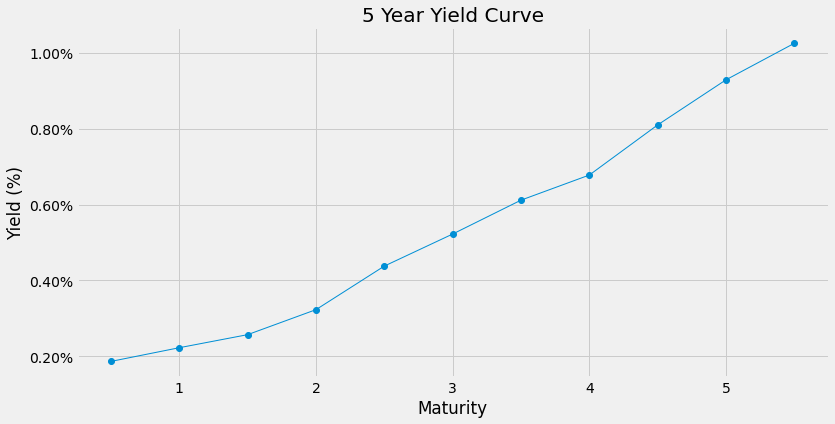

In [14]:
from matplotlib.ticker import PercentFormatter
time = np.linspace(0.5, 5.5, 11)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, yields, marker='o', linestyle='solid', linewidth=1)
ax.set_title('5 Year Yield Curve')
ax.set_xlabel('Maturity')
ax.set_ylabel('Yield (%)')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Bootstrapping
Below is a function that will bootstrap the zero curves based on a collection of bonds.  It is a simple recursive implementation of the process outlined in section 1.2.  Zero-rates are interpolated linearly and used to discount coupons for dates that are not defined explicitly.

In [15]:
from scipy import interpolate

def bootstrap(prices, coupons, times, spots=None, spot_times=None):
    """
    Recursive function that bootstraps the spot curve given a list of prices, coupons and coupon times (years).
    - prices: list of bond prices
    - coupons: list of bond coupons
    - times: list of lists of cash flow times per bond (years)
    - spots: list of spot rates, to be determined recursively 
    """
    if spot_times is None:
        spot_times=[0]
    if spots is None:
        spots = [0]
        
    # base case:
    if len(prices) == 0:
        return spots, spot_times
    
    p = prices[0]
    c = coupons[0]
    f = 100          # face val
    m = 2            # semi-annual
    t = times[0]
    spot_times.append(t[-1]) 

    # find first rate
    if len(spots) == 0: 
        
        for time in t:
            discount_cf = 0
            r = -math.log(p / (f + c*(1/m))) / (t[0])
            spots.append(r)
            
            # remove used bond data
            prices.remove(p)
            coupons.remove(c)
            times.remove(t)
        return bootstrap(prices, coupons, times, spots, spot_times)
        
    # recursive case 
    if len(spots) < 2: # Cannot linearly interpolate with < 2 spot rates

        discount_coupon = 0
        i=0
        for time in t[:-1]:
            discount_coupon += (c/m)*math.e**(-time*spots[i]) # determine discounted coupons
            i+=1
        spot = -math.log((p - discount_coupon) / (f + c / m)) / t[-1] # determine rate
        spots.append(spot)
    else:
        discount_coupon = 0
        interp_rates = interp1d(spot_times[:-1], spots)
        for time in t[:-1]:
            interp_spot = interp_rates(time)
            discount_coupon += (c/m)*math.e**(-time*interp_spot) # determine discounted coupons using an interpolated rate
        spot = -math.log((p - discount_coupon) / (f + c / m)) / t[-1] # determine rate
        spots.append(spot)

    prices.remove(p)
    coupons.remove(c)
    times.remove(t)
    # should return the interpolated list of spots
    return bootstrap(prices, coupons, times, spots, spot_times)


In [16]:
def get_times(x):
    return [x[10] + 0.5*i for i in range(int(x[13]))]

prices = list(working_bonds['Dirty Price'])
coupons = list(working_bonds['Coupon ($)'])
times = list(working_bonds.apply(get_times, axis=1))
sr, st = bootstrap(prices, coupons, times)
interp_zero_rate = interp1d(st, sr)

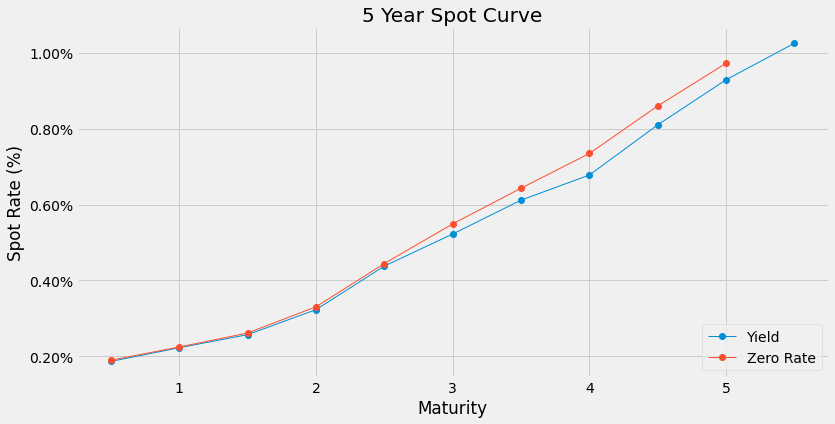

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, yields, 'o', linestyle='solid', linewidth=1, label='Yield')
ax.plot(time[:-1], interp_zero_rate(time[:-1]), 'o', linestyle='solid', linewidth=1, label='Zero Rate')
ax.set_title('5 Year Spot Curve')
ax.set_xlabel('Maturity')
ax.set_ylabel('Spot Rate (%)')
plt.legend(loc='lower right')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# 5. Forward Curve
Here we apply the result in (8) to calculate forward rates.  Note that rates for years 1, 2, 3, 4 ahead are found and interpolated to fill in half years.  

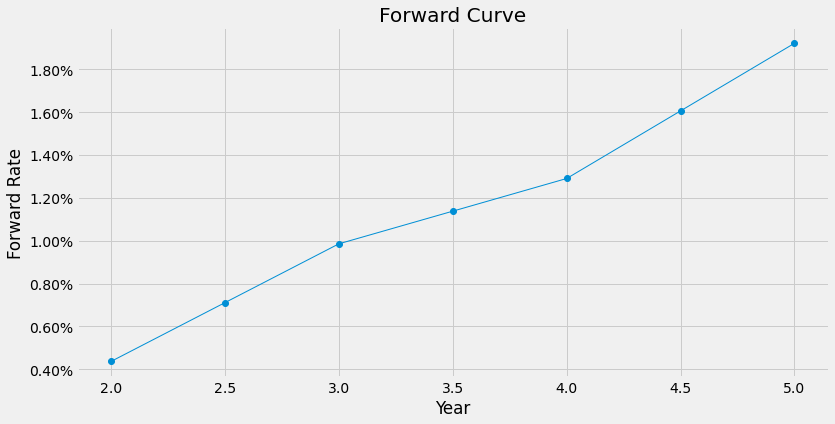

In [23]:
forward_rates = []
forward_years = [1, 2, 3, 4, 5]
for T1, T2 in zip(forward_years[:-1], forward_years[1:] + forward_years[:1]):
    R1 = interp_zero_rate(T1)
    R2 = interp_zero_rate(T2)
    
    R_F = (R2*T2 - R1*T1) / (T2 - T1)
    forward_rates.append(R_F)

interp_forward_rate = interp1d(forward_years[1:], forward_rates)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time[3:-1], interp_forward_rate(time[3:-1]), 'o', linestyle='solid', linewidth=1)
ax.set_title('Forward Curve')
ax.set_ylabel('Forward Rate')
ax.set_xlabel('Year')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

This concludes our report.  In summary we have determined yield, spot and forward curves associated with the Canadian Treasury.  These curves have many applications within fixed income and serve as a benchmark when comparing other securities.  All the information we have gathered in summarized in the table below. 

In [77]:
figures = list(zip(time, yields, interp_zero_rate(time[:-1])))
summary_figures = pd.DataFrame(figures, columns=['time', 'Yield', 'Spot'])
forward_vals = np.array(interp_forward_rate(time[3:-1]))
forward_vals = np.append((np.nan, np.nan, np.nan), forward_vals)
summary_figures['forward'] = forward_vals
summary_figures.set_index('time')

,Yield,Spot,forward
time,,,
0.5,0.001869,0.001901,NaN
1.0,0.002229,0.002248,NaN
1.5,0.002573,0.002616,NaN
2.0,0.003232,0.003307,0.004365
2.5,0.004379,0.004446,0.007111
3.0,0.005223,0.005490,0.009856
3.5,0.006115,0.006430,0.011381
4.0,0.006777,0.007344,0.012906
4.5,0.008097,0.008596,0.016064
